In [5]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss


def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

def hp_filter_decomp(df_ts):

    # Hodrick-Prescott Filter
    hw_cycle, hw_trend = sm.tsa.filters.hpfilter(df_ts)
    hw_year_decomp = df_ts.copy()
    hw_year_decomp['cycle'] = hw_cycle
    hw_year_decomp['trend'] = hw_trend
    hw_year_decomp.plot()

    for y in range(1980, 2020):
        plt.axvline(x = str(y), linestyle='--', c ='black', alpha = 0.2)

    plt.legend()

def stl_decomp(df_ts, period = 5, plot_seasonal = True):
    stl = STL(df_ts, period = period)
    res = stl.fit()
    seasonal, trend, resid = res.seasonal, res.trend, res.resid
    estimated = seasonal + trend

    plt.figure(figsize=(13,7))
    df_ts.plot()
    trend.plot()
    estimated.plot(label ='estimated')
    if(plot_seasonal):
        seasonal.plot()
    plt.legend()

os.chdir('/Users/witnes/Workspace/MDA/Peru-MDA-Ship')

In [6]:

df_country_ts_dim = pd.read_csv('data/dim_all_country_info.csv',
    index_col = ['country', 'year']
    )
df_country_ts_dim.loc[:, ['HWF','HWD','HWN']] = df_country_ts_dim.loc[:, ['HWF','HWD','HWN']].fillna(0)
df_country_ts_dim['is_hw_happend'] = df_country_ts_dim.HWN.apply(lambda r : r > 0)
df_country_ts_dim.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 8720 entries, ('AW', 1980) to ('ZW', 2019)
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   country.1               8720 non-null   object 
 1   total_population        8631 non-null   float64
 2   urban_pop_ratio         8592 non-null   float64
 3   forest_area_ratio       6106 non-null   float64
 4   gdp_growth_rate         7375 non-null   float64
 5   gdp_growth_usd          7479 non-null   float64
 6   co2_emission_kt         7082 non-null   float64
 7   agri_land_ratio         7744 non-null   float64
 8   name                    8720 non-null   object 
 9   region                  8720 non-null   object 
 10  adminregion             5400 non-null   object 
 11  incomeLevel             8720 non-null   object 
 12  lendingType             8720 non-null   object 
 13  capitalCity             8440 non-null   object 
 14  longitude            

In [12]:
df_country_ts_dim.head()

country.1  total_population  urban_pop_ratio  forest_area_ratio  \
country year                                                                   
AW      1980       ABW           60096.0           50.472                NaN   
        1981       ABW           60567.0           50.456                NaN   
        1982       ABW           61345.0           50.441                NaN   
        1983       ABW           62201.0           50.426                NaN   
        1984       ABW           62836.0           50.411                NaN   

              gdp_growth_rate  gdp_growth_usd  co2_emission_kt  \
country year                                                     
AW      1980              NaN             NaN        10498.621   
        1981              NaN             NaN         9999.909   
        1982              NaN             NaN        11180.683   
        1983              NaN             NaN         5746.189   
        1984              NaN             NaN        14348.971   

              agri_land_ratio   name                      region  ...  \
country year                                                      ...   
AW      1980        11.111111  Aruba  Latin America & Caribbean   ...   
        1981        11.111111  Aruba  Latin America & Caribbean   ...   
        1982        11.111111  Aruba  Latin America & Caribbean   ...   
        1983        11.111111  Aruba  Latin America & Caribbean   ...   
        1984        11.111111  Aruba  Latin America & Caribbean   ...   

             longitude latitude num_of_weather_station land_area_sq_km  HWF  \
country year                                                                  
AW      1980  -70.0167  12.5167                      1           180.0  0.0   
        1981  -70.0167  12.5167                      1           180.0  0.0   
        1982  -70.0167  12.5167                      1           180.0  0.0   
        1983  -70.0167  12.5167                      1           180.0  0.0   
        1984  -70.0167  12.5167                      1           180.0  0.0   

              HWD  HWN  HWA  HWM  is_hw_happend  
country year                                     
AW      1980  0.0  0.0  NaN  NaN          False  
        1981  0.0  0.0  NaN  NaN          False  
        1982  0.0  0.0  NaN  NaN          False  
        1983  0.0  0.0  NaN  NaN          False  
        1984  0.0  0.0  NaN  NaN          False  

[5 rows x 24 columns]

#### HWN  yearly number of heat waves
#### HWF yearly sum of participating heat waves
####  HWN length of the longest yearly event
#### HWA hottest day of hottest yearly event
#### HWM average magnitude of all yearly heat waves

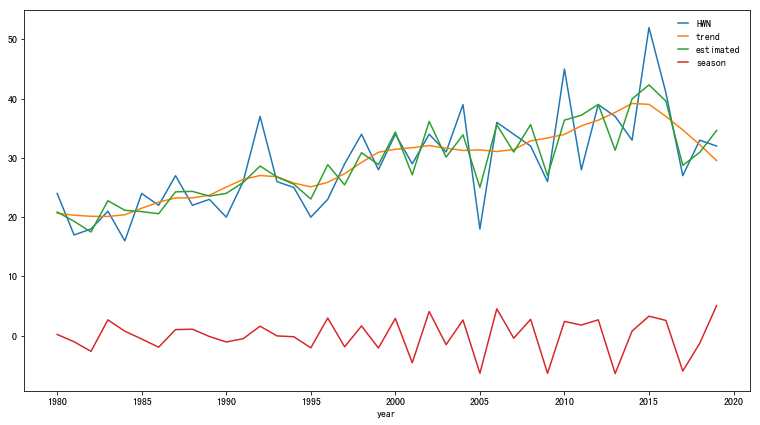

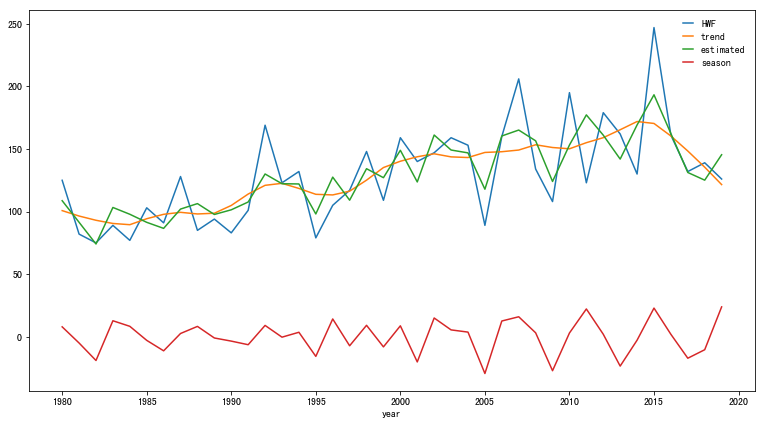

In [7]:
## Frequency
df_hwd_ts = df_country_ts_dim.groupby(['year'])['HWN'].sum()
stl_decomp(df_ts= df_hwd_ts, period = 4)


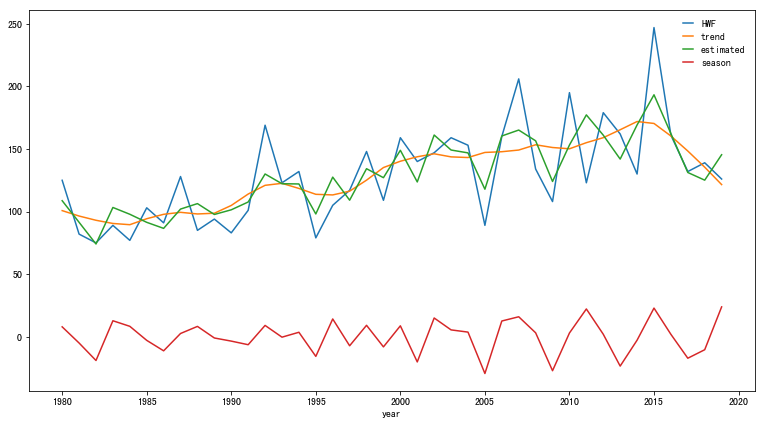

In [10]:
## Duration (Total days of Heat Waves)

df_hwf_ts = df_country_ts_dim.groupby(['year'])['HWF'].sum()
stl_decomp(df_ts= df_hwf_ts, period = 4)

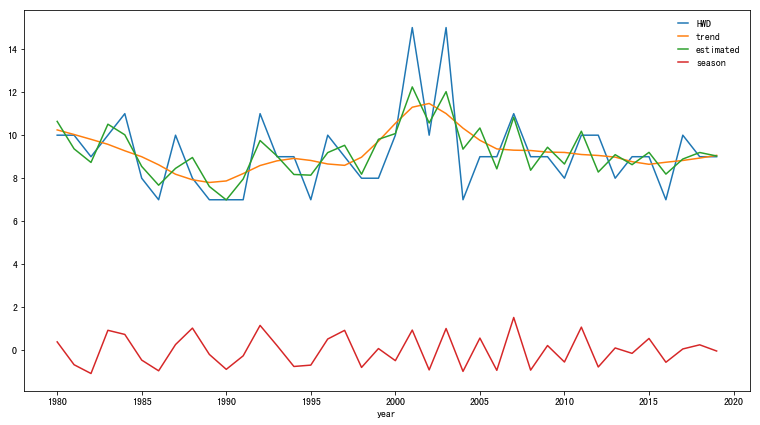

In [9]:
## Duration (Longest days of Heat Waves)
df_hwd_ts = df_country_ts_dim.groupby(['year'])['HWD'].max()
stl_decomp(df_ts= df_hwd_ts, period = 4)

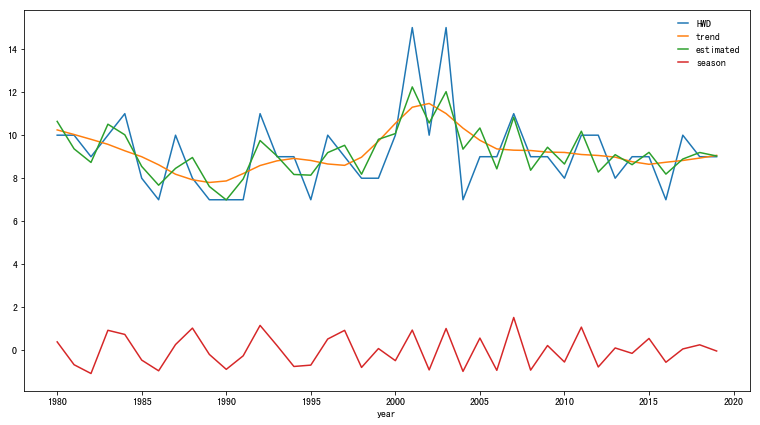

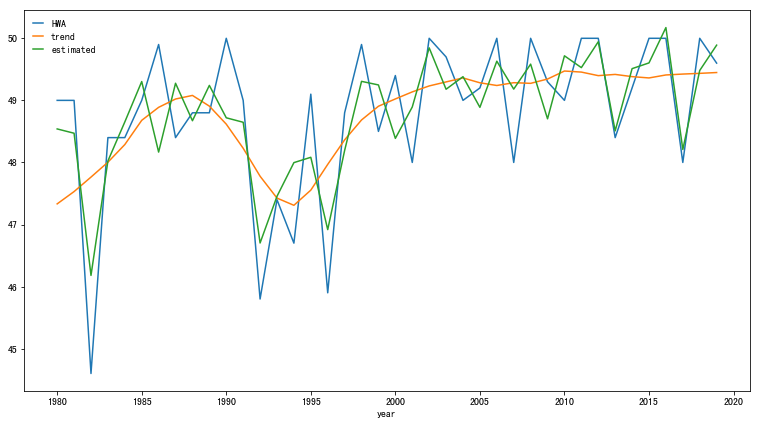

In [8]:
## Intensity (Hottest day of hottest yearly event)
df_hwa_ts = df_country_ts_dim.groupby(['year'])['HWA'].max()
stl_decomp(df_ts= df_hwa_ts, period = 4, plot_seasonal = False)

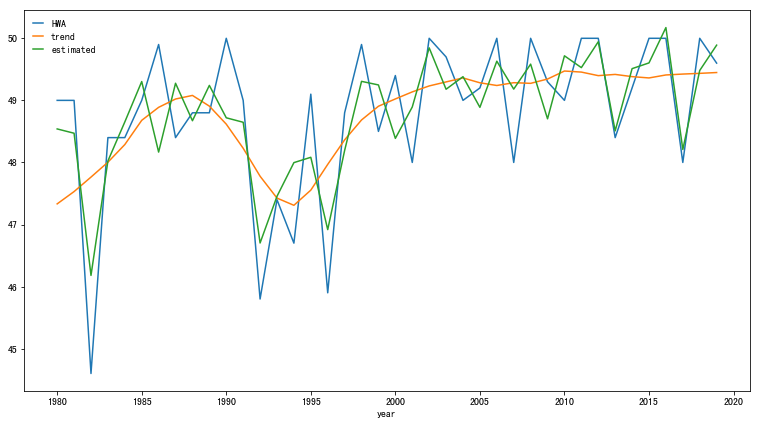

In [13]:
## Intensity (average magnitude of all yearly heat waves)
df_hwm_ts = df_country_ts_dim.groupby(['year'])['HWM'].mean()
stl_decomp(df_ts= df_hwa_ts, period = 4, plot_seasonal = False)

In [ ]:
df_country_ts_dim.info()
# %%

obs_start = '1980-01'
obs_end = '2020-01'

df_ts_month = pd.merge(
    left = pd.DataFrame(
        index = pd.date_range(start= obs_start, end = obs_end, freq='M').to_period('M')
    ),
    right = df_heat_wave[df_heat_wave.Continent.isin(['Asia', 'Europe'])]\
        .groupby('start_year_month')['ISO'].count().rename('num_of_heat_waves'),
    how = 'left',
    left_index = True, right_index= True
).fillna(0)

df_ts_year = pd.merge(
    left = pd.DataFrame(
        index = pd.date_range(start= obs_start, end = obs_end, freq='Y').to_period('Y').astype(str)
    ),
    right = df_heat_wave[df_heat_wave.Continent.isin(['Asia', 'Europe'])]\
        .groupby(df_heat_wave['Year'].astype(str))['ISO'].count()\
        .rename('num_of_heat_waves'),
    how = 'left',
    left_index = True, right_index= True
).fillna(0)

df_ts_month.plot()
df_ts_year.plot()

for y in range(1980, 2020):
    plt.axvline(x = str(y), linestyle='--', c ='black', alpha = 0.2)

In [ ]:

sm.graphics.tsa.plot_pacf(trend.subtract(trend.shift(1) ,axis=0).dropna(), lags=80)
#sm.graphics.tsa.plot_acf(trend.subtract(trend.shift(1) ,axis=0).dropna(), lags=10)

In [ ]:

arma_mod = ARIMA(endog = trend, order = (5,1,0))
arma_res = arma_mod.fit()

arma_res.summary()

plot_predict(arma_res,start='2000', end ='2020')
